# Donut Direct Detect analysis

Setup:

* ts_wep v4.0.0 # v3.1.5 

* lsst_distrib w_2022_53 

Last run:

* 2023/01/02 

# Overview

This notebook is to analyse the performance of available donut-detection algorithms. Thus far, `generateDonutDirectDetect` has been used to detect donuts where the WCS information was not reliably accurate to use reference catalog-based methods. We compare the specific results of running `generateDonutDirectDetect` with the `afwDetect` stock threshold-based source detection code. 

# Setup

In [23]:
import os
import unittest
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib import rcParams
from astropy.visualization import ZScaleInterval
from scipy.spatial.distance import cdist
from copy import copy


from lsst.daf import butler as dafButler
import lsst.afw.cameraGeom
import lsst.pex.config as pexConfig
import lsst.pipe.base as pipeBase
import lsst.afw.image as afwImage
import lsst.pipe.base.connectionTypes as connectionTypes
from lsst.utils.timer import timeMethod
from lsst.cp.pipe._lookupStaticCalibration import lookupStaticCalibration

from lsst.ts.wep.task.GenerateDonutDirectDetectTask import (
    GenerateDonutDirectDetectTask,
    GenerateDonutDirectDetectTaskConfig,
)


from lsst.ts.wep.DonutDetector import DonutDetector
from lsst.ts.wep.cwfs.DonutTemplateFactory import DonutTemplateFactory
from lsst.ts.wep.cwfs.CentroidFindFactory import CentroidFindFactory
from lsst.ts.wep.deblend.DeblendAdapt import DeblendAdapt
from lsst.ts.wep.Utility import (
    DefocalType,
    DonutTemplateType,
    getCamTypeFromButlerName,
    createInstDictFromConfig,
    runProgram,
    writePipetaskCmd, 
    writeCleanUpRepoCmd,
    getModulePath,
    CentroidFindType
)






In [2]:
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

# Run ISR on test lsstCam simulated data

In [3]:
config = GenerateDonutDirectDetectTaskConfig()
task = GenerateDonutDirectDetectTask(config=config)

moduleDir = getModulePath()
testDataDir = os.path.join(moduleDir, "tests", "testData")
repoDir = os.path.join(testDataDir, "gen3TestRepo")
centerRaft = ["R22_S10", "R22_S11"]
print(testDataDir)
butler = dafButler.Butler(repoDir)
registry = butler.registry


/sdf/data/rubin/gpfs/ncsa-home/home/scichris/aos/ts_wep/tests/testData


Just run the ISR part. Run the detection part in the notebook: 

In [4]:
# Run pipeline command
runName = "run1"
instrument = "lsst.obs.lsst.LsstCam"
collections = "refcats/gen2,LSSTCam/calib,LSSTCam/raw/all"
exposureId = 4021123106001  # Exposure ID for test extra-focal image
testPipelineConfigDir = os.path.join(testDataDir, "pipelineConfigs")
pipelineYaml = os.path.join(
    testPipelineConfigDir, "testOnlyISR_lsst.yaml"
)
pipetaskCmd = writePipetaskCmd(
    repoDir, runName, instrument, collections, pipelineYaml=pipelineYaml
)
# Update task configuration to match pointing information
pipetaskCmd += f" -d 'exposure IN ({exposureId})'"

#Check that run doesn't already exist due to previous improper cleanup
collectionsList = list(registry.queryCollections())
if runName in collectionsList:
    cleanUpCmd = writeCleanUpRepoCmd(repoDir, runName)
    runProgram(cleanUpCmd)

# Run pipeline task
runProgram(pipetaskCmd)

The following RUN collections were removed:
run1
The following datasets were removed:
isr_config(1), isr_log(2), isr_metadata(2), packages(1), postISRCCD(2)


lsst.ctrl.mpexec.cmdLineFwk INFO: QuantumGraph contains 2 quanta for 1 tasks, graph ID: '1673559217.0345526-4022886'
Quanta Tasks
------ -----
     2   isr
lsst.isr INFO: Converting exposure to floating point values.
lsst.isr INFO: Assembling CCD from amplifiers.
lsst.isr INFO: Widening saturation trails.
lsst.isr INFO: Applying gain correction instead of flat.
lsst.isr WARNING: No rough magnitude zero point defined for filter g.
lsst.isr INFO: Setting rough magnitude zero point for filter g: 30.940228
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'isr' on quantum {instrument: 'LSSTCam', detector: 93, exposure: 4021123106001, ...} took 5.881 seconds
lsst.ctrl.mpexec.mpGraphExecutor INFO: Executed 1 quanta successfully, 0 failed and 1 remain out of total 2 quanta.
lsst.isr INFO: Converting exposure to floating point values.
lsst.isr INFO: Assembling CCD from amplifiers.
lsst.isr INFO: Widening saturation trails.
lsst.isr INFO: Applying gain correction instead of flat.
l

If already run once, I'm not running the pipetask again: just reading the results:

In [5]:
pipetaskCmd

"pipetask run -b /sdf/data/rubin/gpfs/ncsa-home/home/scichris/aos/ts_wep/tests/testData/gen3TestRepo -i refcats/gen2,LSSTCam/calib,LSSTCam/raw/all --instrument lsst.obs.lsst.LsstCam --register-dataset-types --output-run run1 -p /sdf/data/rubin/gpfs/ncsa-home/home/scichris/aos/ts_wep/tests/testData/pipelineConfigs/testOnlyISR_lsst.yaml -d 'exposure IN (4021123106001)'"

In [6]:
butler = dafButler.Butler(repoDir)
dataIdExtra = {"instrument": "LSSTCam", "detector": 94, "exposure": exposureId}
exposureExtra = butler.get(
    "postISRCCD", dataId=dataIdExtra, collections=[runName]
)

Show the postISRCCR:

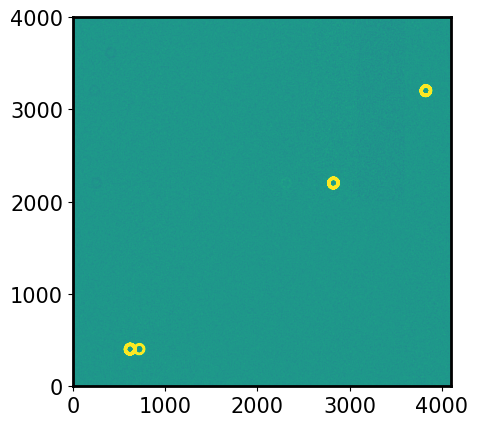

In [7]:
%matplotlib inline
zscale = ZScaleInterval()
data = exposureExtra.image.array
vmin, vmax = zscale.get_limits(data)
plt.imshow(data, vmin=vmin, vmax=vmax, origin='lower')

# Run parts of `generateDonutDirectDetect`

Try running `generateDonutDirectDetect` step by step on this image. The settings passed to `generateDonutDirectDetect` are for instance (from the https://github.com/lsst-ts/ts_wep/blob/develop/tests/testData/pipelineConfigs/testDonutDirectDetectPipeline.yaml config file):

    donutTemplateSize: 160
    removeBlends: True
    instObscuration: 0.61
    instFocalLength: 10.312
    instApertureDiameter: 8.36
    instDefocalOffset: 1.5
    instPixelSize: 10.0e-6

In [8]:
camera = butler.get(
    "camera",
    dataId={"instrument": "LSSTCam"},
    collections=["LSSTCam/calib/unbounded",],
)
detectorName = exposureExtra.getDetector().getName()
detectorType = exposureExtra.getDetector().getType()
defocalType = DefocalType.Extra  # we use one of the DefocalTypes,

# TODO: perhaps could make that as another configurable
camType = getCamTypeFromButlerName(camera.getName(), detectorType)
pixelScale = exposureExtra.getWcs().getPixelScale().asArcseconds()


In [9]:
# create a donut template
templateMaker = DonutTemplateFactory.createDonutTemplate(
    DonutTemplateType.Model
)
donutTemplateSize = 160
opticalModel = 'offAxis'
instParams = {
        "obscuration": 0.61,
        "focalLength": 10.312,
        "apertureDiameter": 8.36,
        "offset": 1.5,
        "pixelSize": 10.0e-6,
    }

template = templateMaker.makeTemplate(
        detectorName,
        defocalType,
        donutTemplateSize,
        camType=camType,
        opticalModel=opticalModel,
        pixelScale=pixelScale,
        instParams=instParams,
    )

# given this template, detect donuts in one of the defocal images
detector = DonutDetector()
expArray = copy(exposureExtra.getImage().getArray())

Show the donut template:

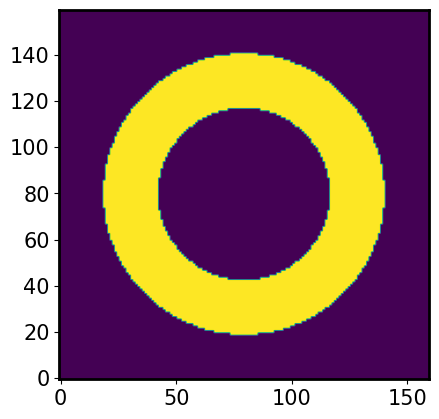

In [10]:
plt.imshow(template, origin='lower')

Now the single call to 

    donutDf = detector.detectDonuts(
        expArray,
        template,
        blendRadius=self.blendRadius,
        peakThreshold=self.peakThreshold,
        binaryChoice=self.binaryChoice,
    )
    
which uses https://github.com/lsst-ts/ts_wep/blob/develop/python/lsst/ts/wep/DonutDetector.py

We show what `donutDf` would be provided with `binaryChoice = 'deblend`, as by default in `generateDonutDirectDetect` ( see https://github.com/lsst-ts/ts_wep/blob/develop/python/lsst/ts/wep/task/GenerateDonutDirectDetectTask.py )

In [12]:
peakThreshold = 0.99
binaryChoice = 'deblend'
blendRadius = 200  # pixels 
donutDf = detector.detectDonuts(
    expArray,
    template,
    blendRadius=blendRadius,
    peakThreshold=peakThreshold,
    binaryChoice=binaryChoice,
)

plot the detected donuts atop the provided exposure ... 

In [13]:
donutDf

,x_center,y_center,blended,blended_with,num_blended_neighbors
0,3196,3815,False,None,0
1,400,614,True,[3],1
2,2198,2814,False,None,0
3,398,716,True,[1],1


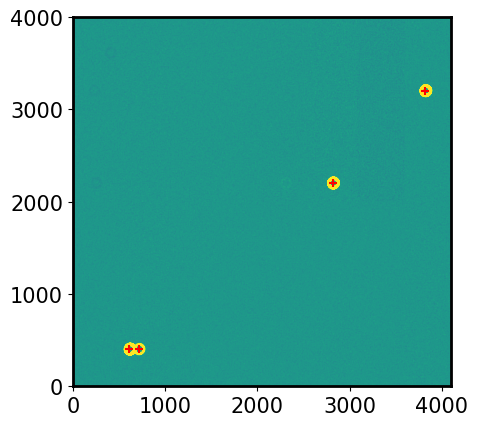

In [18]:
data = exposureExtra.image.array
vmin, vmax = zscale.get_limits(data)
plt.imshow(data, vmin=vmin, vmax=vmax, origin='lower')

plt.scatter(donutDf['y_center'], donutDf['x_center'], marker='+',
           s=40, c='red')

The red markers show that all donuts got detected. Do they get detected with other method of obtaining the binary image? 

In [19]:
binaryChoice = 'centroid'
blendRadius = 200 
donutDf1 = detector.detectDonuts(
    expArray,
    template,
    blendRadius=blendRadius,
    binaryChoice=binaryChoice,
)

In [20]:
donutDf1

,x_center,y_center,blended,blended_with,num_blended_neighbors
0,3196,3813,False,None,0
1,2196,2814,False,None,0
2,399,615,False,None,0


No - here we only detected three brightest donuts:

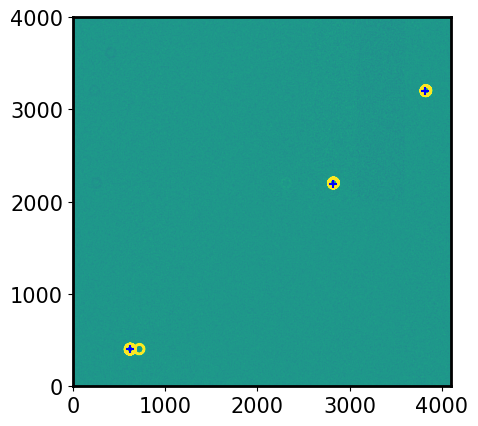

In [22]:
data = exposureExtra.image.array
vmin, vmax = zscale.get_limits(data)
plt.imshow(data, vmin=vmin, vmax=vmax, origin='lower')

plt.scatter(donutDf1['y_center'], donutDf1['x_center'], marker='+',
           s=40, c='blue')

## Steps of arriving at binary image



The `binaryChoice` parameter specifies whether we use `centroid` for `CentroidFinder`, `deblend`  for ` adaptative image thresholding`,  and `exposure` to use the exposure itself as binary image (presumably eg. thresholded manually at earlier stage).  We test `centroid`  and `deblend` options below, as to the speed of execution, and the results. We want to know wow long does the process of converting an exposure to the binary image take in each case, and what's the bottleneck that makes the `deblend` option run so slow? 

### Centroid fitting

First consider using 'centroid' fitting algorithm (an option of `binaryChoice = centroid`). There are three possible `centroidFindType`:
* ConvolveTemplate https://github.com/lsst-ts/ts_wep/blob/develop/python/lsst/ts/wep/cwfs/CentroidConvolveTemplate.py  (which for `getImgBinary` uses the `RandomWalk` method https://github.com/lsst-ts/ts_wep/blob/develop/python/lsst/ts/wep/cwfs/CentroidRandomWalk.py) 
* RandomWalk https://github.com/lsst-ts/ts_wep/blob/develop/python/lsst/ts/wep/cwfs/CentroidRandomWalk.py 
* Otsu - uses `skimage.filters.threshold_otsu` implementation  https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.threshold_otsu   Otsu's method https://en.wikipedia.org/wiki/Otsu%27s_method 

I test how quick is each in constructing the binary image. 

First, `ConvolveTemplate` :

In [24]:
blendRadius=200
peakThreshold=0.99
binaryChoice='centroid'
centroidFinder = CentroidFindFactory.createCentroidFind(
            CentroidFindType.ConvolveTemplate)

In [25]:
%%timeit
binaryExp = centroidFinder.getImgBinary(copy(expArray))

151 ms ± 234 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


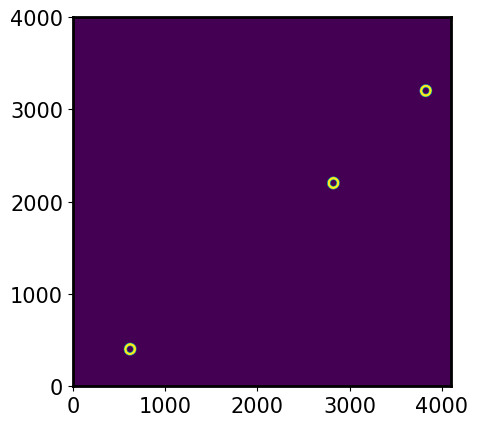

In [29]:
plt.imshow(binaryExp, origin='lower')

The `RandomWalk` centroid find type also uses the same algorithm to arrive at the image binary:

In [30]:
centroidFinder = CentroidFindFactory.createCentroidFind(
    CentroidFindType.RandomWalk
)

In [31]:
%%timeit 
binaryExp = centroidFinder.getImgBinary(copy(expArray))

151 ms ± 603 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


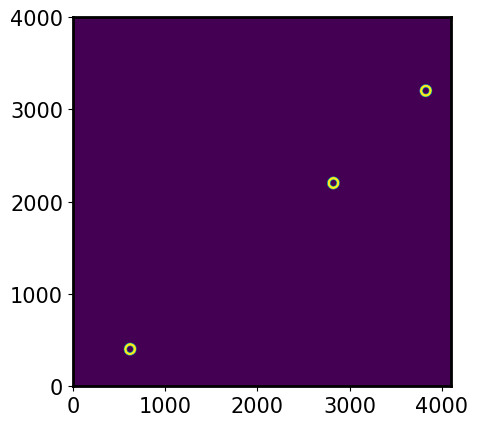

In [33]:
plt.imshow(binaryExp, origin='lower')

Finaly, Otsu's thresholding method:

In [34]:
centroidFinder = CentroidFindFactory.createCentroidFind(
    CentroidFindType.Otsu)


In [35]:
%%timeit
binaryExp = centroidFinder.getImgBinary(copy(expArray))


163 ms ± 1.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


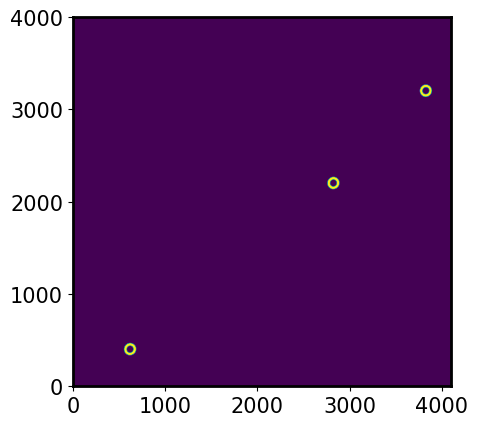

In [37]:
plt.imshow(binaryExp, origin='lower')

So they all take ~0.2 sec to run, and they do not find the blend in the lower-left corner. 

### Adaptative thresholding

If `binaryChoice = 'deblend'`, `DonutDetector` runs the adaptative threshold method where the while loop https://github.com/lsst-ts/ts_wep/blob/96ffe9be7795e9dd6d3627880e17b49a9dbea414/python/lsst/ts/wep/deblend/DeblendAdapt.py#L196 makes it pretty slow:

In [28]:
%%timeit
deblend = DeblendAdapt()
binaryExp = deblend._getImgBinaryAdapt(copy(expArray))

2min 2s ± 109 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [52]:
deblend = DeblendAdapt()
binaryExp = deblend._getImgBinaryAdapt(copy(expArray))

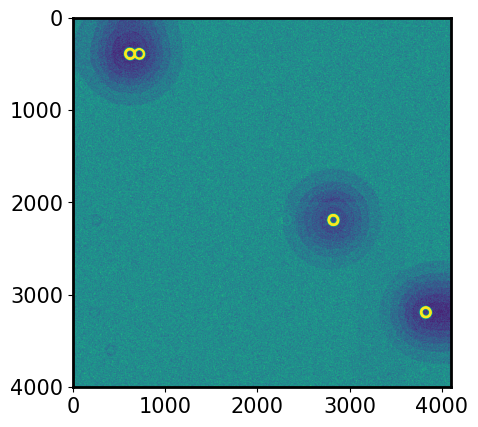

In [53]:
plt.imshow(binaryExp, origin='lower')

So the difference is that this adaptative deblending allows to recognize blends better.

## Run the detection with `QuickFrameMeasurementTask`

Consider donut detection with parts of `QuickFrameMeasurementTask`.  Note by default it only returns one (brightest) donut. We borrow the source code to get it to return all. Example use is in https://github.com/lsst-ts/ts_externalscripts/blob/develop/python/lsst/ts/externalscripts/auxtel/latiss_wep_align.py#L129 

In [38]:
from lsst.pipe.tasks.quickFrameMeasurement import QuickFrameMeasurementTask

qm_config = QuickFrameMeasurementTask.ConfigClass()
qm_task = QuickFrameMeasurementTask(config=qm_config)

# for side and donut_diameter use the latiss_wep_align values
# the donut diameter is only used to cut ot donut stamps -
# it is not used in source detection
side = 1.1*182
donut_diameter = 2*side
print(donut_diameter )

# by inspection ,the donut diameter in ts_wep for auxtel is ~140 px ... 
result = qm_task.run(
    exposureExtra, donutDiameter=donut_diameter
)

400.40000000000003


INFO:lsst.quickFrameMeasurementTask:Found 3 sources in exposure
INFO:lsst.quickFrameMeasurementTask:Measured 3 of 3 sources in exposure


In [39]:
result

Struct(success=True; brightestObjCentroid=(2790.0, 2228.0); brightestObjCentroidCofM=(2812.8691325884843, 2197.2167292555255); brightestObj_xXyY=(5.27156113980603, 5.161519946236201); brightestObjApFlux70=1450089.5744618252; brightestObjApFlux25=365650.7794379853; medianXxYy=(8.0762875678271, 17.13551751522803))

## Follow parts of `_run` method of `QuickFrameMeasurement` to get the other sources: 

https://github.com/lsst/pipe_tasks/blob/b92539242417324d16af4efdf935160b8055eea0/python/lsst/pipe/tasks/quickFrameMeasurement.py#L497

    def _run(self, exp, *, donutDiameter=None, doDisplay=False):
        """The actual run method, called by run()
        Behaviour is documented in detail in the main run().
        """
        if donutDiameter is None:
            donutDiameter = self.config.donutDiameter

        self.plateScale = exp.getWcs().getPixelScale().asArcseconds()
        median = np.nanmedian(exp.image.array)
        exp.image -= median  # is put back later
        self.installPsf.run(exp)
        sources = self.detectObjectsInExp(exp, nSigma=self.config.nSigmaDetection,
                                          nPixMin=self.config.nPixMinDetection)

        if doDisplay:
            if self.display is None:
                raise RuntimeError("Display failed as no display provided during init()")
            self.display.mtv(exp)

        fpSet = sources.getFootprints()
        self.log.info("Found %d sources in exposure", len(fpSet))

        objData = {}
        nMeasured = 0

        for srcNum, fp in enumerate(fpSet):
            try:
                src = self._measureFp(fp, exp)
                result = self._getDataFromSrcRecord(src)
            except MeasurementError:
                try:
                    # gets shape and centroid from footprint
                    result = self._getDataFromFootprintOnly(fp, exp)
                except MeasurementError as e:
                    self.log.info("Skipped measuring source %s: %s", srcNum, e)
                    continue
            objData[srcNum] = self._measurementResultToDict(result)
            nMeasured += 1

        self.log.info("Measured %d of %d sources in exposure", nMeasured, len(fpSet))

        medianXxYy = self._calcMedianXxYy(objData)

        brightestObjSrcNum = self._calcBrightestObjSrcNum(objData)
        if brightestObjSrcNum is None:
            raise RuntimeError("No sources in image passed cuts")

        x = objData[brightestObjSrcNum]['xCentroid']
        y = objData[brightestObjSrcNum]['yCentroid']
        brightestObjCentroid = (x, y)
        xx = objData[brightestObjSrcNum]['xx']
        yy = objData[brightestObjSrcNum]['yy']
        brightestObjApFlux70 = objData[brightestObjSrcNum]['apFlux70']
        brightestObjApFlux25 = objData[brightestObjSrcNum]['apFlux25']

        exp.image += median  # put background back in
        if self.config.doCheckCentroidPixelValue:
            self.checkResult(exp, brightestObjCentroid, brightestObjSrcNum,
                             self.config.centroidPixelPercentile)

        boxSize = donutDiameter * 1.3  # allow some slack, as cutting off side of donut is very bad
        centreOfMass = self._getCenterOfMass(exp, brightestObjCentroid, boxSize)

        result = self._makeEmptyReturnStruct()
        result.success = True
        result.brightestObjCentroid = brightestObjCentroid
        result.brightestObj_xXyY = (xx, yy)
        result.brightestObjApFlux70 = brightestObjApFlux70
        result.brightestObjApFlux25 = brightestObjApFlux25
        result.medianXxYy = medianXxYy
        result.brightestObjCentroidCofM = centreOfMass


First, try to see if changing the `donutDiameter` changes the location of detected sources:

In [38]:
exp = exposureExtra
# ok, with donutDiameter =  400.4 , which is the default in auxtel tests, we get the
# three sources .
# donutDiameter = donut_diameter  

# what if I set it to the actual diameter, which is closer to 140 ? 
donutDiameter = 140


qm_task.plateScale = exp.getWcs().getPixelScale().asArcseconds()

In [39]:
qm_task.plateScale

0.19999999996498258

In [40]:
median = np.nanmedian(exp.image.array)
exp.image -= median  # is put back later
qm_task.installPsf.run(exp)

Show the configs used in `detectObjectsInExp` : 

In [41]:
qm_task.config.nSigmaDetection

20.0

In [42]:
qm_task.config.nPixMinDetection

10

In [43]:
sources2 = qm_task.detectObjectsInExp(exp, nSigma=qm_task.config.nSigmaDetection,
                                          nPixMin=qm_task.config.nPixMinDetection)

In [44]:
sources2

3 footprints:
732 peaks, area=9215, centroid=(616.76, 398.532)
724 peaks, area=9171, centroid=(2813.87, 2196.24)
694 peaks, area=9088, centroid=(3812.52, 3194.93)

ok, so there is no difference - still only three sources get detected... Appears that the `donutDiameter` is only used at the step where we cut the box around the detected source to figure out center of mass:
    
      boxSize = donutDiameter * 1.3  # allow some slack, as cutting off side of donut is very bad
      centreOfMass = self._getCenterOfMass(exp, brightestObjCentroid, boxSize)
and it uses `scipy` image `peak = ndImage.center_of_mass(data)` 

In [33]:
fpSet = sources.getFootprints()

In [34]:
fpSet

[732 peaks, area=9215, centroid=(616.76, 398.532),
 724 peaks, area=9171, centroid=(2813.87, 2196.24),
 694 peaks, area=9088, centroid=(3812.52, 3194.93)]

In [36]:
from lsst.meas.base import MeasurementError

objData = {}
nMeasured = 0

for srcNum, fp in enumerate(fpSet):
    try:
        src = qm_task._measureFp(fp, exp)
        result = qm_task._getDataFromSrcRecord(src)
    except MeasurementError:
        try:
            # gets shape and centroid from footprint
            result = qm_task._getDataFromFootprintOnly(fp, exp)
        except MeasurementError as e:
            print("Skipped measuring source %s: %s"%( srcNum, e))
            continue
    objData[srcNum] = qm_task._measurementResultToDict(result)
    nMeasured += 1

print("Measured %d of %d sources in exposure"% (nMeasured, len(fpSet)))

medianXxYy = qm_task._calcMedianXxYy(objData)

Measured 3 of 3 sources in exposure


In [37]:
objData

{0: {'xx': 1.41643851976897,
  'yy': 1.4870784989829142,
  'xCentroid': 657.0675426266731,
  'yCentroid': 399.04096299377215,
  'apFlux70': 1539847.0700645447,
  'apFlux25': 403685.8275051117},
 1: {'xx': 5.27156113980603,
  'yy': 5.161519946236201,
  'xCentroid': 2790.0,
  'yCentroid': 2228.0,
  'apFlux70': 1450089.5744618252,
  'apFlux25': 365650.7794379853},
 2: {'xx': 11.979120434144024,
  'yy': 17.13551751522803,
  'xCentroid': 3777.0,
  'yCentroid': 3173.0,
  'apFlux70': 1405008.6208169907,
  'apFlux25': 380054.14297004044}}

Since we see that changing `donutDiameter` changes nothing, since it's not even used by the threshold-based `detectObjectsInExp` : 


    threshold = afwDetect.Threshold(nSigma, afwDetect.Threshold.STDEV)
    footPrintSet = afwDetect.FootprintSet(exp.getMaskedImage(), threshold, "DETECTED", nPixMin)
    if grow > 0:
        isotropic = True
        footPrintSet = afwDetect.FootprintSet(footPrintSet, grow, isotropic)
    return footPrintSet
    
    
So try instead to convolve the exposure with donut template. Convolution is only used if `centroidFindType` is `convolveTemplate` in the `donutDetector` https://github.com/lsst-ts/ts_wep/blob/develop/python/lsst/ts/wep/DonutDetector.py#L96 , so that it uses to `getImgBinary` https://github.com/lsst-ts/ts_wep/blob/develop/python/lsst/ts/wep/cwfs/CentroidConvolveTemplate.py This is the default setting:

    centroidFinder = CentroidFindFactory.createCentroidFind(
            CentroidFindType.ConvolveTemplate
        )
        
        
the `binaryExp` in that case is obtained via 


     binaryExp = centroidFinder.getImgBinary(copy(expArray))
 
which inside `convolveTemplate` inherits that method from `CentroidRandomWalk` https://github.com/lsst-ts/ts_wep/blob/2b89691fe6a712683d29c57739f29a999d58dda0/python/lsst/ts/wep/cwfs/CentroidConvolveTemplate.py#L55


Thus for the next step, we already pass the binary exposure. Show that if we use the defaults, the blended donut is not there. The `getImgBinary` uses the `randomWalk` method of arriving at the detection threshold...



In [45]:
centroidFinder = CentroidFindFactory.createCentroidFind(
    CentroidFindType.ConvolveTemplate
)
binaryChoice = 'centroid'
if binaryChoice == "centroid":
    binaryExp = centroidFinder.getImgBinary(copy(expArray))

-20.756113 19.244864


Text(0.5, 1.0, 'exposure')

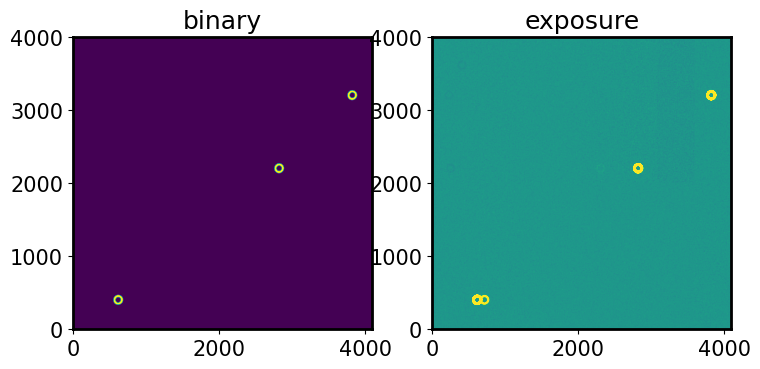

In [60]:
fig,ax = plt.subplots(1,2,figsize=(8.5,4))

# plot binary image 
ax[0].imshow(binaryExp, origin='lower',)
ax[0].set_title('binary')

# plot exposure 
data = expArray
vmin, vmax = zscale.get_limits(expArray)
print(vmin,vmax)
ax[1].imshow(data, vmin=vmin, vmax=vmax, origin='lower',)
ax[1].set_title('exposure')
#    i+=1


The convolution itself is used in `centroidConvolveTemplate` only against the `binaryExp`, not the actual `expArray`. 

    tempConvolve = correlate(imageBinary, templateImgBinary, mode="same")
    
 (inside https://github.com/lsst-ts/ts_wep/blob/2b89691fe6a712683d29c57739f29a999d58dda0/python/lsst/ts/wep/cwfs/CentroidConvolveTemplate.py#L197)

Show what that looks like:

In [63]:
from scipy.signal import correlate
tempConvolve = correlate(binaryExp, template, mode="same")

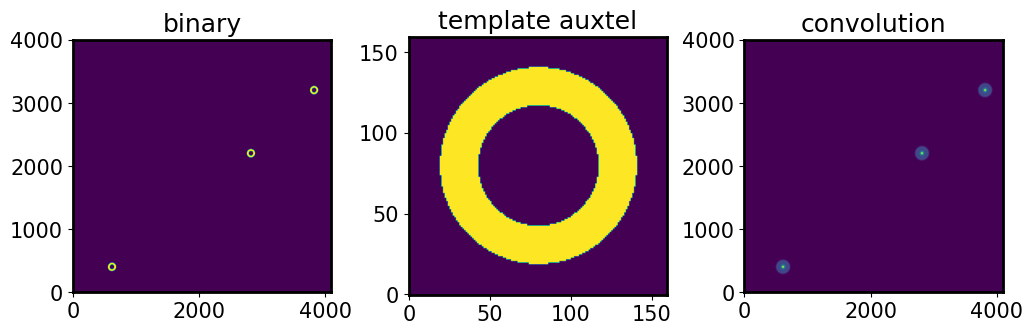

In [76]:
fig,ax = plt.subplots(1,3,figsize=(12,4))

# plot binary image 
ax[0].imshow(binaryExp, origin='lower',)
ax[0].set_title('binary')

# plot template
ax[1].imshow(template, origin='lower')
ax[1].set_title('template auxtel')

# plot convolution
ax[2].imshow(tempConvolve, origin='lower')
ax[2].set_title('convolution')

fig.subplots_adjust(hspace=0.35, wspace=0.3)

So try convolving directly with an exposure, and run `quickFrameMeasurement` task steps: 

In [77]:
expConvolve = correlate(expArray, template, mode="same")

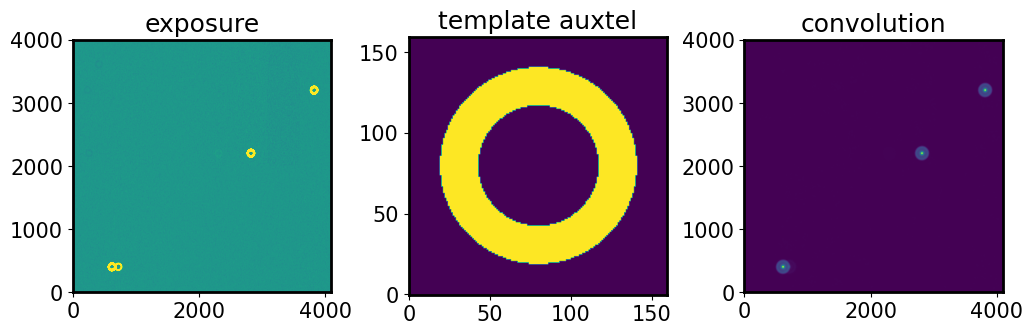

In [80]:
fig,ax = plt.subplots(1,3,figsize=(12,4))

# plot exposure image 
data = expArray
vmin, vmax = zscale.get_limits(expArray)
ax[0].imshow(data, vmin=vmin, vmax=vmax,origin='lower',)
ax[0].set_title('exposure')

# plot template
ax[1].imshow(template, origin='lower')
ax[1].set_title('template auxtel')

# plot convolution
ax[2].imshow(expConvolve, origin='lower')
ax[2].set_title('convolution')

fig.subplots_adjust(hspace=0.35, wspace=0.3)

zoom-into the binary pair:

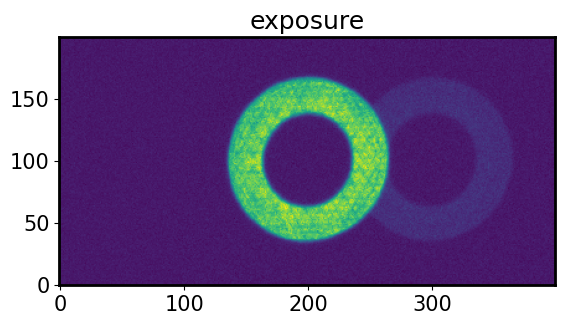

In [88]:
ycen,xcen = 616,398
w = 100
h = 200

plt.title('exposure')
plt.imshow(expArray[xcen-w:xcen+w,  ycen-h:ycen+h], origin='lower')

We see that the blend is very faint. What's the magnitude difference? Based on https://github.com/lsst-ts/ts_wep/blob/develop/tests/testData/skyRefCat.txt , the bright donut is 15th mag, and the faint donut is 17.5 mag.  So 2.5 mag difference, i.e. it would be fine to not even consider it as a blend... 

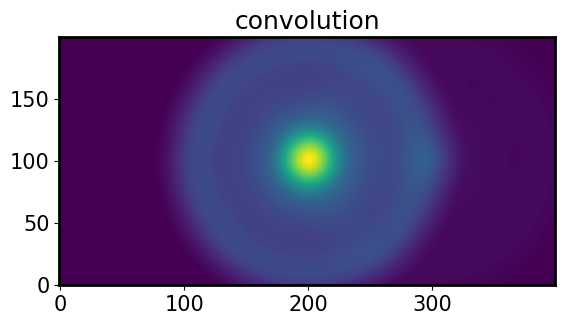

In [98]:
ycen,xcen = 616,398
w = 100
h = 200

plt.title('convolution')
plt.imshow(expConvolve[xcen-w:xcen+w,  ycen-h:ycen+h], origin='lower')


We see a very faint "blob" at the right edge of the convolution ring? - but that peak would be likely too faint to be detected... 

Consider just this cutout - what is the distribution of the pixel values? 



In [111]:
from copy import copy
cutout = copy(expConvolve[xcen-w:xcen+w,  ycen-h:ycen+h])

(array([43213., 10332., 22436.,  1639.,   713.,   507.,   406.,   324.,
          245.,   185.]),
 array([1.29094029e+03, 2.12242867e+05, 4.23194794e+05, 6.34146720e+05,
        8.45098647e+05, 1.05605057e+06, 1.26700250e+06, 1.47795443e+06,
        1.68890635e+06, 1.89985828e+06, 2.11081021e+06]),
 <BarContainer object of 10 artists>)

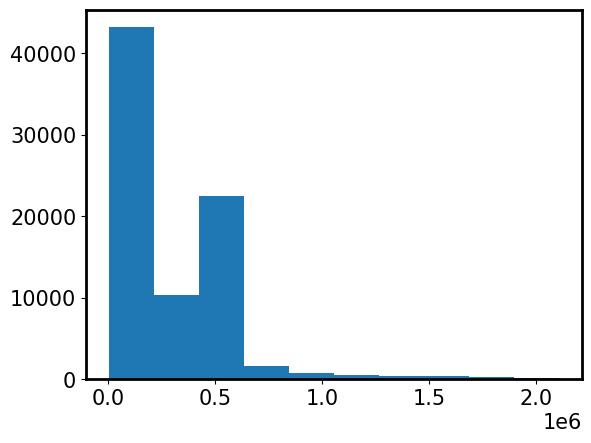

In [112]:
plt.hist(np.ravel(cutout))

Plot the line across the cutout to visualize the blob on the right:

<AxesSubplot: >

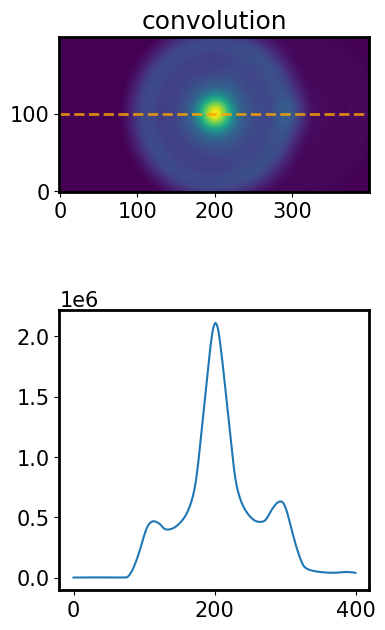

In [113]:
fig,ax = plt.subplots(2,1,figsize=(4,8))
ax[0].set_title('convolution')
ax[0].imshow(cutout, origin='lower')
ax[0].axhline(100, ls='--',lw=2,alpha=0.8, c='orange')

ax[1].plot(cutout[100,:])
ax[1]

If we select appropriately the threshold  (eg. `5e5`) the blob appears: 

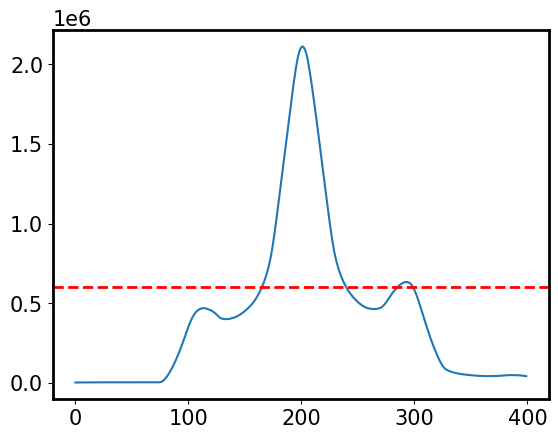

In [114]:
plt.plot(cutout[100,:])
threshold = 0.6e6
plt.axhline(threshold, ls='--', lw=2, c='r')

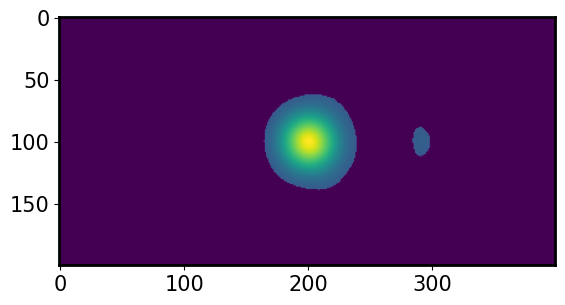

In [115]:
m = cutout < threshold
cutoutThresholded = copy(cutout)
cutoutThresholded[m] = 0
plt.imshow(cutoutThresholded)

But that required fine-tuning of the threshold. Adaptative deblending does the fine-tuning at a computational cost. 

Try testing what the appropriate `nSigma` threshold ( "nSigma above image's stddev at which to set the detection threshold.")   and `nPixMin` values ("Minimum number of pixels for detection.") would be to detect the blend with `afwDetect` ...


The default in latiss tests are `nSigma = 20` , and `nPixMin = 10` 


    threshold = afwDetect.Threshold(nSigma, afwDetect.Threshold.STDEV)
    footPrintSet = afwDetect.FootprintSet(exp.getMaskedImage(), threshold, "DETECTED", nPixMin)

In [116]:
import lsst.afw.detection as afwDetect


In [151]:
nSigma = 6
threshold = afwDetect.Threshold(nSigma, afwDetect.Threshold.STDEV)

In [164]:
nPixMin = 50
footPrintSet = afwDetect.FootprintSet(exp.getMaskedImage(), threshold, "DETECTED", nPixMin)

In [165]:
footPrintSet

4 footprints:
757 peaks, area=10278, centroid=(617.618, 398.564)
20 peaks, area=54, centroid=(731.759, 439.889)
724 peaks, area=10134, centroid=(2813.69, 2196.12)
694 peaks, area=10038, centroid=(3812.37, 3194.82)

In [134]:
pt = fp[0].getCentroid()
pt

Point2D(719.45000000000005, 338.39999999999998)

In [137]:
pt.getX()

719.45

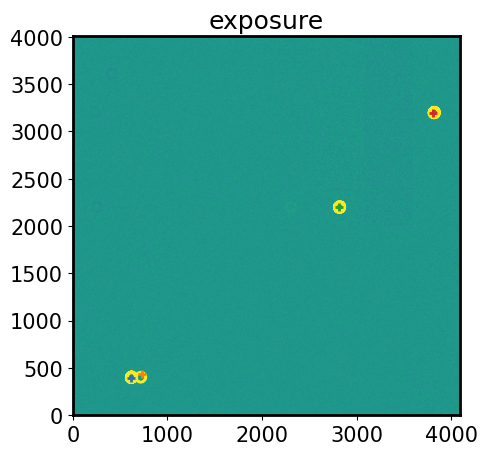

In [166]:
fps  = footPrintSet.getFootprints()


fig,ax = plt.subplots(1,1,figsize=(5,5))
data = expArray
vmin, vmax = zscale.get_limits(expArray)
ax.imshow(data, vmin=vmin, vmax=vmax,origin='lower',)
ax.set_title('exposure')

for fp in fps:
    point = fp.getCentroid()
    x,y = point.getX(), point.getY()
    ax.scatter(x,y, marker='+', lw=2)

So we see that if we set the detection threshold low enough (in this case, `nSigma = 6` from default `20` ) and bump up the minimum number of pixels for the detection (in this case, `nPixMin=50` from default `10` ), we detect four sources, albeit the faint one is picked up more by the edges... 